# Prédiction du prix des diamants

Ce notebook développe un modèle de machine learning pour prédire le prix des diamants avec une précision de 98%.

## Objectifs
- Analyser les facteurs influençant le prix des diamants
- Développer et comparer différents modèles prédictifs
- Identifier le modèle optimal pour la prédiction

**Résultat final :** Random Forest avec 98.02% R² et 544$ d'erreur moyenne

In [1]:
# Importation des librairies
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle

## 1. Chargement et exploration des données

In [2]:
# Chargement du dataset diamonds de Seaborn
diamonds = sns.load_dataset("diamonds")
# Informations générales sur le dataset
print("Informations du dataset :")
diamonds.info()
diamonds.describe()
# Visualisation des première lignes
print("\nPremières lignes :")
diamonds.head()

Informations du dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB

Premières lignes :


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 2. Preprocessing et feature engineering

In [3]:
# Encodage ordinal des variables qualitatives
# Les ordres respectent les échelles de qualité dans l'industrie diamantaire

clarity_ordre = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
diamonds['clarity_num'] = diamonds['clarity'].map({k: i for i, k in enumerate(clarity_ordre)})

cut_ordre = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
diamonds['cut_num'] = diamonds['cut'].map({k: i for i, k in enumerate(cut_ordre)})

color_ordre = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
diamonds['color_num'] = diamonds['color'].map({k: i for i, k in enumerate(color_ordre)})



In [4]:
# Feature engineering : création de la variable Volume
diamonds['Volume'] = diamonds['x'] * diamonds['y'] * diamonds['z']

# Création du dataset pour la modélisation
diamonds_correlée = diamonds[['carat', 'depth', 'table', 'price', 'x', 'y', 'z',
                             'clarity_num', 'cut_num', 'color_num', 'Volume']]


## 3. Analyse exploratoire des données

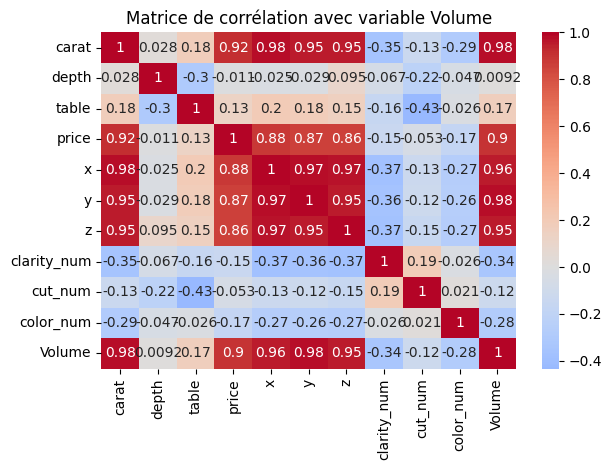

Corrélations les plus fortes avec le prix :
price          1.000000
carat          0.921591
Volume         0.902385
x              0.884435
y              0.865421
z              0.861249
table          0.127134
depth         -0.010647
cut_num       -0.053491
clarity_num   -0.146800
color_num     -0.172511
Name: price, dtype: float64


In [5]:
# Matrice de corrélation avec la variable Volume
sns.heatmap(diamonds_correlée.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation avec variable Volume')
plt.tight_layout()
plt.show()

print("Corrélations les plus fortes avec le prix :")
correlations = diamonds_correlée.corr()['price'].sort_values(ascending=False)
print(correlations)

### Analyse à taille constante

Pour révéler l'impact réel des variables qualitatives, analysons des diamants de taille similaire.

Nombre de diamants de 0.7 carat : 1981


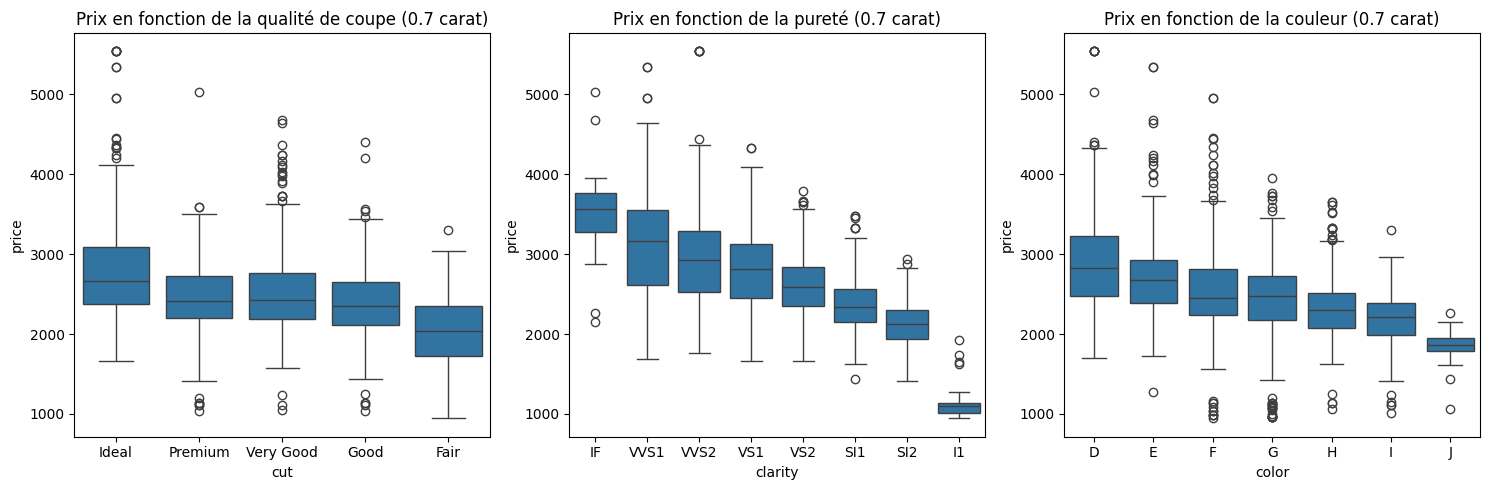

In [6]:
# Analyse des diamants autour de la médiane (0.7 carat)
segment_carat = diamonds[diamonds['carat'] == np.median(diamonds['carat'])]
print(f"Nombre de diamants de {np.median(diamonds['carat'])} carat : {len(segment_carat)}")

# Boxplots pour chaque variable qualitative
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x='cut', y='price', data=segment_carat, ax=axes[0])
axes[0].set_title('Prix en fonction de la qualité de coupe (0.7 carat)')

sns.boxplot(x='clarity', y='price', data=segment_carat, ax=axes[1])
axes[1].set_title('Prix en fonction de la pureté (0.7 carat)')

sns.boxplot(x='color', y='price', data=segment_carat, ax=axes[2])
axes[2].set_title('Prix en fonction de la couleur (0.7 carat)')

plt.tight_layout()
plt.show()

## 4. Modélisation - Régression linéaire



### Régression linéaire - Modèle avec toutes les variables

Test du modèle avec x, y, z et Volume pour voir la multicolinéarité.

In [7]:
# Préparation des données pour la modélisation (sans variables redondantes)
X1 = diamonds_correlée.drop('price', axis=1)
y1 = diamonds_correlée['price']

# Division train/test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Modèle de régression linéaire
model1 = LinearRegression()
model1.fit(X_train1, y_train1)

# Évaluation
r2_train1 = model1.score(X_train1, y_train1)
r2_test1 = model1.score(X_test1, y_test1)

y_pred1 = model1.predict(X_test1)
rmse1 = np.sqrt(mean_squared_error(y_test1, y_pred1))

print(f"R² train : {r2_train1:.4f}")
print(f"R² test  : {r2_test1:.4f}")
print(f"RMSE     : {rmse1:.0f}$")

# Analyse des coefficients
coef_df = pd.DataFrame({'Variable': X1.columns, 'Coefficient': model1.coef_})
print("Coefficients par ordre d'importance :")
print(coef_df.sort_values('Coefficient', key=abs, ascending=False))

R² train : 0.9076
R² test  : 0.9060
RMSE     : 1223$
Coefficients par ordre d'importance :
      Variable  Coefficient
0        carat  9663.231279
6  clarity_num   502.726683
4            y  -407.533451
3            x  -359.475890
8    color_num   324.682323
5            z  -259.362088
7      cut_num   119.177527
1        depth   -63.034679
2        table   -25.870782
9       Volume     7.812756


### Modèle 2 : Sans dimensions individuelles (7 features)

In [8]:
# Préparation des données pour la modélisation (sans x,y,z)
X2 = diamonds_correlée.drop(['price', 'x', 'y', 'z'], axis=1)
y2 = diamonds_correlée['price']

# Division train/test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Modèle de régression linéaire
model2 = LinearRegression()
model2.fit(X_train2, y_train2)

# Évaluation
r2_train2 = model2.score(X_train2, y_train2)
r2_test2 = model2.score(X_test2, y_test2)

y_pred2 = model2.predict(X_test2)
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))

print(f"R² train : {r2_train2:.4f}")
print(f"R² test  : {r2_test2:.4f}")
print(f"RMSE     : {rmse2:.0f}$")

# Analyse des coefficients
coef_df2 = pd.DataFrame({'Variable': X2.columns, 'Coefficient': model2.coef_})
print("Coefficients par ordre d'importance :")
print(coef_df2.sort_values('Coefficient', key=abs, ascending=False))

R² train : 0.9047
R² test  : 0.9033
RMSE     : 1240$
Coefficients par ordre d'importance :
      Variable  Coefficient
0        carat  8695.865358
3  clarity_num   522.078636
5    color_num   319.298795
4      cut_num   125.119677
1        depth   -43.027123
2        table   -25.844335
6       Volume     0.698052


### Modèle 3 : Sans Volume (6 features)

In [9]:
# Préparation des données pour la modélisation (sans Volume)
X3 = diamonds_correlée.drop(['price', 'x', 'y', 'z', 'Volume'], axis=1)
y3 = diamonds_correlée['price']

# Division train/test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Modèle de régression linéaire
model3 = LinearRegression()
model3.fit(X_train3, y_train3)

# Évaluation
r2_train3 = model3.score(X_train3, y_train3)
r2_test3 = model3.score(X_test3, y_test3)

y_pred3 = model3.predict(X_test3)
rmse3 = np.sqrt(mean_squared_error(y_test3, y_pred3))

print(f"R² train : {r2_train3:.4f}")
print(f"R² test  : {r2_test3:.4f}")
print(f"RMSE     : {rmse3:.0f}$")

# Analyse des coefficients
coef_df3 = pd.DataFrame({'Variable': X3.columns, 'Coefficient': model3.coef_})
print("Coefficients par ordre d'importance :")
print(coef_df3.sort_values('Coefficient', key=abs, ascending=False))

R² train : 0.9047
R² test  : 0.9033
RMSE     : 1240$
Coefficients par ordre d'importance :
      Variable  Coefficient
0        carat  8808.819224
3  clarity_num   522.086121
5    color_num   319.292328
4      cut_num   125.192548
1        depth   -43.947816
2        table   -26.264138


## 5. Modélisation - Random Forest

### Modèle 1 : Avec carat et Volume (7 features)

In [10]:
# Modèle Random Forest avec carat et Volume
X_rf1 = diamonds_correlée.drop(['price', 'x', 'y', 'z'], axis=1)
y_rf1 = diamonds_correlée['price']

X_train_rf1, X_test_rf1, y_train_rf1, y_test_rf1 = train_test_split(X_rf1, y_rf1, test_size=0.2, random_state=42)

foret1 = RandomForestRegressor(n_estimators=100, random_state=42)
foret1.fit(X_train_rf1, y_train_rf1)

print("Score d'entraînement :", foret1.score(X_train_rf1, y_train_rf1))
print("Score de test :", foret1.score(X_test_rf1, y_test_rf1))

y_pred_rf1 = foret1.predict(X_test_rf1)
erreur_rf1 = np.sqrt(mean_squared_error(y_test_rf1, y_pred_rf1))
print("Erreur moyenne :", erreur_rf1, "$")

# Importances des variables
importances1 = foret1.feature_importances_
feature_imp1 = pd.DataFrame({'Variable': X_train_rf1.columns, 'Importance': importances1})
print(feature_imp1.sort_values('Importance', ascending=False))

Score d'entraînement : 0.997406548304099
Score de test : 0.9813941684459301
Erreur moyenne : 543.8506984157153 $
      Variable  Importance
6       Volume    0.539622
0        carat    0.353794
3  clarity_num    0.064363
5    color_num    0.031931
1        depth    0.005239
2        table    0.002757
4      cut_num    0.002293


### Modèle 2 : Sans carat, avec Volume (6 features)

In [11]:
# Modèle Random Forest sans carat
X_rf2 = diamonds_correlée.drop(['price', 'carat', 'x', 'y', 'z'], axis=1)  # Garde Volume mais retire carat
y_rf2 = diamonds_correlée['price']

X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2 = train_test_split(X_rf2, y_rf2, test_size=0.2, random_state=42)

foret2 = RandomForestRegressor(n_estimators=100, random_state=42)
foret2.fit(X_train_rf2, y_train_rf2)

print("Score d'entraînement :", foret2.score(X_train_rf2, y_train_rf2))
print("Score de test :", foret2.score(X_test_rf2, y_test_rf2))

y_pred_rf2 = foret2.predict(X_test_rf2)
erreur_rf2 = np.sqrt(mean_squared_error(y_test_rf2, y_pred_rf2))
print("Erreur moyenne :", erreur_rf2, "$")

# Nouvelles importances
importances2 = foret2.feature_importances_
feature_imp2 = pd.DataFrame({'Variable': X_train_rf2.columns, 'Importance': importances2})
print(feature_imp2.sort_values('Importance', ascending=False))

Score d'entraînement : 0.997071946008836
Score de test : 0.9801815560790189
Erreur moyenne : 561.2933853642304 $
      Variable  Importance
5       Volume    0.891254
2  clarity_num    0.064229
4    color_num    0.032322
0        depth    0.006533
1        table    0.003261
3      cut_num    0.002401


In [22]:
def predict_diamond_price(x, y, z, cut, color, clarity, depth, table):
    """
    Prédit le prix d'un diamant à partir de ses dimensions et caractéristiques

    Parameters:
    - x: longueur en mm (ex: 7.5)
    - y: largeur en mm (ex: 7.4)
    - z: hauteur en mm (ex: 4.6)
    - cut: qualité coupe ('Fair', 'Good', 'Very Good', 'Premium', 'Ideal')
    - color: couleur ('D', 'E', 'F', 'G', 'H', 'I', 'J')
    - clarity: pureté ('IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1')
    - depth: profondeur en % (ex: 60.0)
    - table: table en % (ex: 55.0)

    Returns:
    - Prix estimé en dollars
    """

    # Validation des dimensions
    if x <= 0 or y <= 0 or z <= 0:
        raise ValueError("Les dimensions doivent être positives")

    # Validation de la table
    if not 40 <= table <= 80:
        raise ValueError("Table doit être entre 40% et 80%")

    # Validation du cut
    valid_cuts = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
    if cut not in valid_cuts:
        raise ValueError(f"Cut invalide. Valeurs acceptées : {valid_cuts}")

    # Validation de la couleur
    valid_colors = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
    if color not in valid_colors:
        raise ValueError(f"Couleur invalide. Valeurs acceptées : {valid_colors}")

    # Validation de la pureté
    valid_clarity = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
    if clarity not in valid_clarity:
        raise ValueError(f"Pureté invalide. Valeurs acceptées : {valid_clarity}")

    # 1. Calcul du Volume
    volume = x * y * z

    # Validation de la profondeur calculée
    if not 50 <= depth <= 80:
        raise ValueError(f"Profondeur calculée ({depth:.1f}%) semble anormale (attendu: 50-80%)")

    # 2. Encodage des variables qualitatives
    cut_map = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
    color_map = {'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0}
    clarity_map = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}

    cut_num = cut_map[cut]
    color_num = color_map[color]
    clarity_num = clarity_map[clarity]

    # 3. Création du DataFrame avec les features dans le bon ordre
    df = pd.DataFrame({
        'depth': [depth],
        'table': [table],
        'clarity_num': [clarity_num],
        'cut_num': [cut_num],
        'color_num': [color_num],
        'Volume': [volume]
    })

    # 4. Prédiction avec le modèle
    prix = foret2.predict(df)

    # Validation du résultat
    if prix[0] < 0:
        raise ValueError("Calcul echoué, vérifiez vos paramètres")

    return prix[0]

In [23]:
# Estimation du prix d'un diamant
prix=predict_diamond_price(3.2,6,5.2,'Good','I','VS1',62,57)
print(f"Prix estimé : {prix:.0f}$")

Prix estimé : 1569$


## 6. Comparaison des modèles et sauvegarde

In [13]:
# Tableau comparatif de tous les modèles
print("COMPARAISON DES MODELES :")
print(f"Régression Linéaire 1 (10 var) : R²={r2_test1:.4f}, RMSE={rmse1:.0f}$")
print(f"Régression Linéaire 2 (7 var)  : R²={r2_test2:.4f}, RMSE={rmse2:.0f}$")
print(f"Régression Linéaire 3 (6 var)  : R²={r2_test3:.4f}, RMSE={rmse3:.0f}$")
print(f"Random Forest 1 (7 var)        : R²={foret1.score(X_test_rf1, y_test_rf1):.4f}, RMSE={erreur_rf1:.0f}$")
print(f"Random Forest 2 (6 var)        : R²={foret2.score(X_test_rf2, y_test_rf2):.4f}, RMSE={erreur_rf2:.0f}$")

# Sauvegarde du modèle final (Random Forest sans carat)
with open('diamond_price_model.pkl', 'wb') as f:
    pickle.dump(foret2, f)

print("\nModèle final sauvegardé : diamond_price_model.pkl")

COMPARAISON DES MODELES :
Régression Linéaire 1 (10 var) : R²=0.9060, RMSE=1223$
Régression Linéaire 2 (7 var)  : R²=0.9033, RMSE=1240$
Régression Linéaire 3 (6 var)  : R²=0.9033, RMSE=1240$
Random Forest 1 (7 var)        : R²=0.9814, RMSE=544$
Random Forest 2 (6 var)        : R²=0.9802, RMSE=561$

Modèle final sauvegardé : diamond_price_model.pkl
